In [1]:
import numpy as np, sys
from scipy import ndimage, interpolate
import matplotlib.pyplot as plt

In [2]:
sys.path.insert(0, '../saxstats/')

In [3]:
import saxstats
DENSS_GPU=False

In [4]:
rho_apo, side = saxstats.read_mrc('2cm7_apo.mrc')

In [5]:
rho_ligand, side = saxstats.read_mrc('2cm7_ligand.mrc')

In [7]:
rho_ligand_ = np.fft.fftn(rho_ligand)
rho_ligand_ *= 1.1
rho_ligand_mod = np.fft.ifftn(rho_ligand_)
saxstats.write_mrc(rho_ligand_mod.real, side, '2cm7_ligand_1.1.mrc')

In [13]:
def raster_unit_sphere(num=200):
    L = np.sqrt(num * np.pi);
    pt = []
    for i in range(num):
        h = 1.0 - (2.0 * i + 1.0) / num
        p = np.arccos(h)
        t = L * p
        xu = np.sin(p) * np.cos(t)
        yu = np.sin(p) * np.sin(t)
        zu = np.cos(p)
        pt.append([xu, yu, zu])

    return np.array(pt)


In [14]:
def mypadbinsum(x, bins, nbins, DENSS_GPU=False):
    xsum = np.bincount(bins.ravel(), x.ravel())
    #xcount = cp.bincount(bins.ravel())
    xret = np.empty(nbins)
    xret[:] = np.nan
    #print(f'bins max {bins.max()}, len xsum {len(xsum)}, nbins {nbins}')
    xret[int(bins.max())+1-len(xsum):int(bins.max())+1] = xsum
    return xret


In [15]:
# Determine patches
num_patch = 26
qpatch_labels = np.zeros_like(qbin_labels)
qxyz = np.array([qx.flatten(), qy.flatten(), qz.flatten()]).T
unitr = raster_unit_sphere(num_patch)
#print(unitr)
closest_patch = np.argmax(qxyz @ unitr.T, axis=1).reshape(rho_apo.shape)




In [23]:
rho_ligand_ = np.fft.fftn(rho_ligand)
print(f'{np.sum(closest_patch==15)} out of {closest_patch.size} will be adjusted')
rho_ligand_[closest_patch==15] *= 1.1
rho_ligand_mod = np.fft.ifftn(rho_ligand_).real
rho_ligand_mod[rho_ligand_mod < 0] = 0
rho_ligand_mod = rho_ligand_mod * np.sum(rho_ligand) / np.sum(rho_ligand_mod)
saxstats.write_mrc(rho_ligand_mod, side, '2cm7_ligand_s15.mrc')

286287 out of 10077696 will be adjusted


In [8]:
rho_mask, side = saxstats.read_mrc('2cm7_ligand.mrc')
ligand_ref = rho_mask > 0
kernel = ndimage.generate_binary_structure(3, 2)
lig_mask = ndimage.binary_dilation(ligand_ref, structure=kernel)

In [9]:
q, I, sigq, Ifit, file_dmax, isfit = saxstats.loadProfile('2cm7.dat', units='A')

In [10]:
dmax = 36
oversampling = 3
voxel = 0.5
D = dmax

#Initialize variables
side = oversampling*D
halfside = side/2

n = int(side/voxel)
#want n to be even for speed/memory optimization with the FFT, ideally a power of 2, but wont enforce that
if n%2==1:
    n += 1
#store n for later use if needed
nbox = n

dx = side/n
dV = dx**3
V = side**3
x_ = np.linspace(-halfside,halfside,n)
x,y,z = np.meshgrid(x_,x_,x_,indexing='ij')
r = np.sqrt(x**2 + y**2 + z**2)
rho_apo *= dV
rho_ligand *= dV

In [11]:
apo_ne = np.sum(rho_apo)
print(apo_ne)
lig_ne = np.sum(rho_ligand)
print(lig_ne)
all_ne = apo_ne + lig_ne

15994.002
230.0


In [12]:
df = 1/side
qx_ = np.fft.fftfreq(x_.size)*n*df*2*np.pi
#print(qx_, np.fft.fftshift(qx_))
qx, qy, qz = np.meshgrid(qx_,qx_,qx_,indexing='ij')
qr = np.sqrt(qx**2+qy**2+qz**2)
qmax = np.max(qr)
qstep = np.min(qr[qr>0]) - 1e-8 #subtract a tiny bit to deal with floating point error
nbins = int(qmax/qstep)
qbins = np.linspace(0,nbins*qstep,nbins+1)
#create modified qbins and put qbins in center of bin rather than at left edge of bin.
qbinsc = np.copy(qbins)
qbinsc[1:] += qstep/2.
#create an array labeling each voxel according to which qbin it belongs
qbin_labels = np.searchsorted(qbins,qr,"right")
qbin_labels -= 1
#allow for any range of q data
qdata = qbinsc[np.where( (qbinsc>=q.min()) & (qbinsc<=q.max()) )]
Idata = np.interp(qdata,q,I)

qextend = qbinsc[qbinsc>=qdata.max()]
Iextend = qextend**-4
Iextend = Iextend/Iextend[0] * Idata[-1]
qdata = np.concatenate((qdata,qextend[1:]))
Idata = np.concatenate((Idata,Iextend[1:]))

#create list of qbin indices just in region of data for later F scaling
qbin_args = np.in1d(qbinsc,qdata,assume_unique=True)
qba = np.copy(qbin_args) #just for brevity when using it later
sigqdata = np.interp(qdata,q,sigq)


In [11]:
Idata.shape

(188,)

In [12]:
scale_factor = all_ne**2 / Idata[0]
Idata *= scale_factor
sigqdata *= scale_factor
I *= scale_factor
sigq *= scale_factor

In [13]:
rho_apo_ = np.fft.fftn(rho_apo)
I3D_apo_ = np.abs(rho_apo_)**2

In [14]:
rho_ligand_ = np.fft.fftn(rho_ligand)
I3D_ligand_ = np.abs(rho_ligand_)**2

In [15]:
rho_all_ = rho_apo_ + rho_ligand_
I3D_all_ = np.abs(rho_all_)**2

In [16]:
Imean_apo_ = saxstats.mybinmean(I3D_apo_, qbin_labels, DENSS_GPU)

In [17]:
Imean_ligand_ = saxstats.mybinmean(I3D_ligand_, qbin_labels, DENSS_GPU)

In [18]:
Imean_all_ = saxstats.mybinmean(I3D_all_, qbin_labels, DENSS_GPU)

262196.8381086539


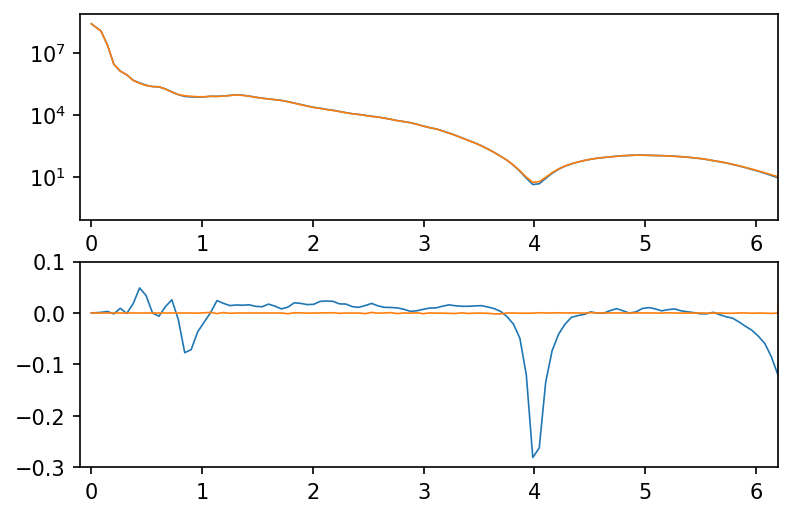

In [19]:
rho_guess = np.zeros_like(rho_ligand)
rho_guess += np.random.random(rho_guess.shape)

rho_guess[~lig_mask] = 0
rho_guess /= np.sum(rho_guess)
rho_guess *= lig_ne

rho_guess_ = np.fft.fftn(rho_guess)
I3D_guess_ = np.abs(rho_apo_ + rho_guess_)**2

Imean_guess_ = saxstats.mybinmean(I3D_guess_, qbin_labels, DENSS_GPU)

fig, ax = plt.subplots(2, 1, dpi=150)
ax[0].plot(qdata[qba], Idata[qba], lw=0.8)
# plt.plot(q, Imean_apo_[qba])
# ax[0].plot(q, Imean_all_[qba])
ax[0].plot(qdata[qba], Imean_guess_[qba], lw=0.8)
ax[0].set_xlim([-0.1, np.max(q)])
# plt.plot(q, Imean_ligand_[qba])
ax[0].set_yscale('log')
ax[1].plot(qdata[qba], (Idata[qba] - Imean_guess_[qba])/Idata, lw=0.8)
ax[1].plot(qdata[qba], (Idata[qba] - Imean_all_[qba])/Idata, lw=0.8)
ax[1].set_xlim([-0.1, np.max(q)])
ax[1].set_ylim([-0.3, 0.1])
# plt.yscale('log')
print(np.sum(Idata - Imean_guess_[qba]))

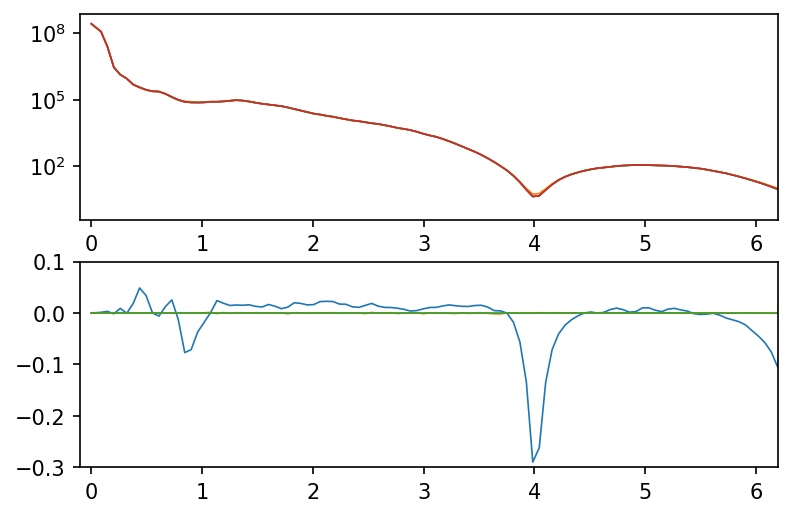

In [22]:
## Try out different ways of data fitting
rho_guess = np.zeros_like(rho_ligand)
rho_guess += np.random.random(rho_guess.shape)

rho_guess[~lig_mask] = 0
rho_guess /= np.sum(rho_guess)
rho_guess *= lig_ne

rho_guess_ = np.fft.fftn(rho_guess)
I3D_guess_ = np.abs(rho_apo_ + rho_guess_)**2
Imean_guess_ = saxstats.mybinmean(I3D_guess_, qbin_labels, DENSS_GPU)

fig, ax = plt.subplots(2, 1, dpi=150)
ax[0].plot(qdata[qba], Idata[qba], lw=0.8)
# plt.plot(q, Imean_apo_[qba])
# ax[0].plot(q, Imean_all_[qba])
ax[0].plot(qdata[qba], Imean_guess_[qba], lw=0.8)
ax[0].set_xlim([-0.1, np.max(q)])
# plt.plot(q, Imean_ligand_[qba])
ax[0].set_yscale('log')
ax[1].plot(qdata[qba], (Idata[qba] - Imean_guess_[qba])/Idata, lw=0.8)
ax[1].plot(qdata[qba], (Idata[qba] - Imean_all_[qba])/Idata, lw=0.8)
ax[1].set_xlim([-0.1, np.max(q)])
ax[1].set_ylim([-0.3, 0.1])


factors = np.sqrt(Idata / Imean_guess_[qba])
rho_guess_all_ = (rho_guess_ + rho_apo_) * factors[qbin_labels]
I3D_guess_all_ = np.abs(rho_guess_all_)**2
Imean_guess_all_ = saxstats.mybinmean(I3D_guess_all_, qbin_labels, DENSS_GPU)
ax[0].plot(qdata[qba], Imean_guess_all_[qba], lw=0.8)
# ax[1].plot(qdata[qba], (Idata[qba] - Imean_guess_all_[qba])/Idata[qba], lw=0.8)


rho_guess_mod_ = rho_guess_ * factors[qbin_labels]
rho_guess_mod_ += rho_apo_ * (factors[qbin_labels] - 1)
rho_apo_mod_ = rho_apo_
I3D_guess_mod_ = np.abs(rho_guess_mod_)**2
I3D_apo_mod_ = np.abs(rho_apo_mod_)**2
Imean_guess_mod_ = saxstats.mybinmean(I3D_guess_mod_, qbin_labels, DENSS_GPU)
Imean_apo_mod_ = saxstats.mybinmean(I3D_apo_mod_, qbin_labels, DENSS_GPU)
I3D_cross_mod_ = 2 * (rho_apo_mod_ * rho_guess_mod_.conjugate()).real
Imean_cross_mod_ = saxstats.mybinmean(I3D_cross_mod_, qbin_labels, DENSS_GPU)
ax[0].plot(qdata[qba], Imean_guess_mod_[qba] + Imean_apo_mod_[qba] + Imean_cross_mod_[qba], lw=0.8)
ax[1].plot(qdata[qba], (Idata[qba] - Imean_guess_mod_[qba] - Imean_apo_mod_[qba] - Imean_cross_mod_[qba])/Idata[qba], lw=0.8)

In [23]:
rho_prime = np.fft.ifftn(rho_guess_mod_)
saxstats.write_mrc(rho_prime.real, side, 'test_back.mrc')

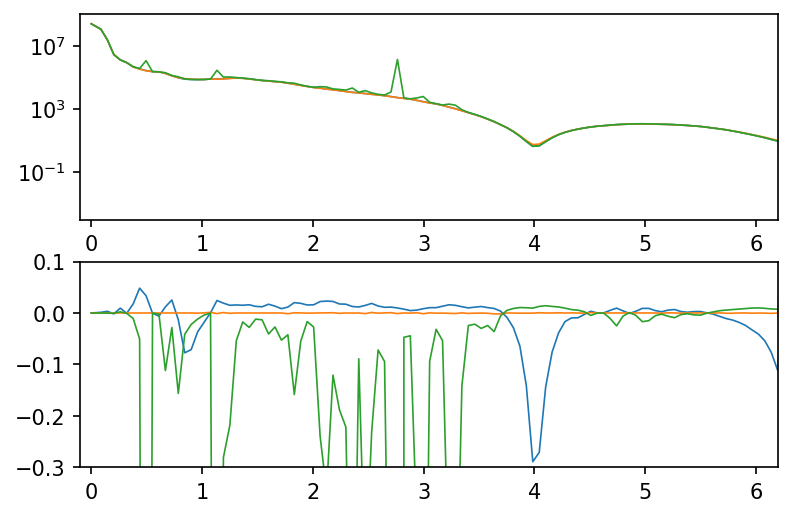

In [21]:
## Try out different ways of data fitting
rho_guess = np.zeros_like(rho_ligand)
rho_guess += np.random.random(rho_guess.shape)

rho_guess[~lig_mask] = 0
rho_guess /= np.sum(rho_guess)
rho_guess *= lig_ne

rho_guess_ = np.fft.fftn(rho_guess)
I3D_guess_ = np.abs(rho_apo_ + rho_guess_)**2
Imean_guess_ = saxstats.mybinmean(I3D_guess_, qbin_labels, DENSS_GPU)

fig, ax = plt.subplots(2, 1, dpi=150)
ax[0].plot(qdata[qba], Idata[qba], lw=0.8)
# plt.plot(q, Imean_apo_[qba])
# ax[0].plot(q, Imean_all_[qba])
ax[0].plot(qdata[qba], Imean_guess_[qba], lw=0.8)
ax[0].set_xlim([-0.1, np.max(q)])
# plt.plot(q, Imean_ligand_[qba])
ax[0].set_yscale('log')
ax[1].plot(qdata[qba], (Idata[qba] - Imean_guess_[qba])/Idata, lw=0.8)
ax[1].plot(qdata[qba], (Idata[qba] - Imean_all_[qba])/Idata, lw=0.8)
ax[1].set_xlim([-0.1, np.max(q)])
ax[1].set_ylim([-0.3, 0.1])


factors = (Idata - Imean_apo_[qba]) / (Imean_guess_[qba] - Imean_apo_[qba])
# factors = (np.sqrt(Idata) - np.sqrt(Imean_apo_[qba])) / (np.sqrt(Imean_guess_[qba]) - np.sqrt(Imean_apo_[qba]))
# factors = np.sqrt(Idata / Imean_guess_[qba])
rho_guess_ *= factors[qbin_labels]# * lig_ne / apo_ne
rho_guess_all_ = (rho_guess_ + rho_apo_)
I3D_guess_all_ = np.abs(rho_guess_all_)**2
Imean_guess_all_ = saxstats.mybinmean(I3D_guess_all_, qbin_labels, DENSS_GPU)
ax[0].plot(qdata[qba], Imean_guess_all_[qba], lw=0.8)
ax[1].plot(qdata[qba], (Idata[qba] - Imean_guess_all_[qba])/Idata[qba], lw=0.8)
# ax[1].plot(qdata[qba], (Idata[qba] - Imean_apo_[qba])/Idata[qba], lw=0.8)


/opt/anaconda3/envs/UB/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/UB/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in sqrt


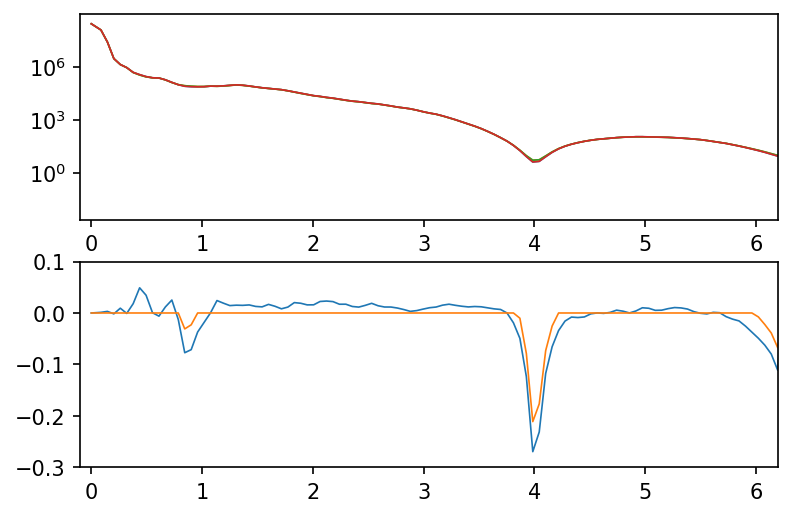

In [73]:
## Try out different ways of data fitting
rho_guess = np.zeros_like(rho_ligand)
rho_guess += np.random.random(rho_guess.shape)

rho_guess[~lig_mask] = 0
rho_guess /= np.sum(rho_guess)
rho_guess *= lig_ne

rho_guess_ = np.fft.fftn(rho_guess)
I3D_guess_ = np.abs(rho_apo_ + rho_guess_)**2
Imean_guess_ = saxstats.mybinmean(I3D_guess_, qbin_labels, DENSS_GPU)

fig, ax = plt.subplots(2, 1, dpi=150)
ax[0].plot(qdata[qba], Idata[qba], lw=0.8)
# plt.plot(q, Imean_apo_[qba])
# ax[0].plot(q, Imean_all_[qba])
ax[0].plot(qdata[qba], Imean_guess_[qba], lw=0.8)
ax[0].set_xlim([-0.1, np.max(q)])
# plt.plot(q, Imean_ligand_[qba])
ax[0].set_yscale('log')
ax[1].plot(qdata[qba], (Idata[qba] - Imean_guess_[qba])/Idata, lw=0.8)
# ax[1].plot(qdata[qba], (Idata[qba] - Imean_all_[qba])/Idata, lw=0.8)
ax[1].set_xlim([-0.1, np.max(q)])
ax[1].set_ylim([-0.3, 0.1])


# Calculate binned mean of that patch
patch_n = 10
Isum_this = mypadbinsum(I3D_guess_[closest_patch==patch_n], qbin_labels[closest_patch==patch_n], nbins+1, DENSS_GPU=DENSS_GPU)
# Calculate binned mean of !that patch
Isum_rest = mypadbinsum(I3D_guess_[closest_patch!=patch_n], qbin_labels[closest_patch!=patch_n], nbins+1, DENSS_GPU=DENSS_GPU)

Idata3D = Idata[qbin_labels]
Isum_data = mypadbinsum(Idata3D, qbin_labels, nbins+1, DENSS_GPU=DENSS_GPU)

#print(Imean_this.shape, Imean_rest.shape, Idata.shape)
# Calculate scaling factor of that patch, to (Idata - mean(!that patch))
factors_this = np.sqrt((Isum_data - Isum_rest)/Isum_this) #FIXME: Get the scaling right
# Limit to a preset limit of 0.2 - 5
factors_this[Isum_data <= Isum_rest] = 0.2
factors_this[np.isnan(factors_this)] = 1
factors_this[factors_this < 0.2] = 0.2
factors_this[factors_this > 5] = 5
#factors_this = factors_this[qbin_labels.ravel()] * F_mask.ravel() + (1 - F_mask.ravel())
# print(factors_this)

# Multiply that patch with this scaling factor
rho_guess_all_ = (rho_guess_ + rho_apo_)
rho_guess_all_[closest_patch==patch_n] *= factors_this[qbin_labels][closest_patch==patch_n]
#F.ravel()[closest_patch==patch_n] *= factors_this.ravel()[closest_patch==patch_n]
I3D_guess_all_ = np.abs(rho_guess_all_)**2
Imean_guess_all_ = saxstats.mybinmean(I3D_guess_all_, qbin_labels, DENSS_GPU=DENSS_GPU)
ax[0].plot(qdata[qba], Imean_guess_[qba], lw=0.8)
ax[1].plot(qdata[qba], (Idata[qba] - Imean_guess_all_[qba])/Idata[qba], lw=0.8)


factors = np.sqrt(Idata / Imean_guess_all_[qba])
rho_guess_all_ = rho_guess_all_ * factors[qbin_labels]
I3D_guess_all_ = np.abs(rho_guess_all_)**2
Imean_guess_all_ = saxstats.mybinmean(I3D_guess_all_, qbin_labels, DENSS_GPU)
ax[0].plot(qdata[qba], Imean_guess_all_[qba], lw=0.8)
# ax[1].plot(qdata[qba], (Idata[qba] - Imean_guess_all_[qba])/Idata[qba], lw=0.8)



In [61]:
closest_patch==patch_n

array([False, False, False, ..., False, False, False])

In [45]:
factors_this[qbin_labels.ravel()][closest_patch==patch_n].shape

(257853,)

In [9]:
rho_prime = np.fft.ifftn(rho_apo_ + rho_ligand_)

In [14]:
saxstats.write_mrc((rho_prime - rho_apo).real, side, 'test_back.mrc')